<h1>
<hr style=" border:none; height:3px;">
<center>Benchmark pipeline</center>
<hr style=" border:none; height:3px;">
</h1>

<center><img src='https://netacad.centralesupelec.fr/img/cs.jpg' width=200></center>

<h4><center>Louis LHOTTE</center></h4>

# Introduction
<div style="background-color: #e3f2fd; padding: 15px; border-radius: 8px; border: 1px solid #81d4fa; display: flex; flex-direction: column; align-items: flex-start; max-width: 1125px;">
  <div style="display: flex; align-items: center; margin-bottom: 10px;">
    <img src="https://img.icons8.com/ios-filled/50/000000/info.png" alt="info" style="margin-right: 15px; width: 30px; height: 30px;">
    <span style="font-size: 16px; font-weight: bold; color: #01579b;">Information:</span>
  </div>
  <p style="font-size: 14px; color: #01579b;">
    After generating two batches of 8 images with four different comfyUI workflows, the database was annotated by humans to score three values: <br>
    - Logo Boolean Score (Yes/No)<br>
    - Aesthetic score (0-10)<br>
    - Business Score (0-10).<br><br>
    Thereafter, the goal is to compare those scores and see if the human feedback is correlated with two additional scores - <b>CLIP score</b> to calculate similarity between prompt and image, or <b>LLM custom scores</b> (with GPT-4o as annotator) detailed in scientific papers - see notes<br>
    For the record, the database was <b>NOT</b> annotated by myself, who generated the logo to avoid any bias.
  </p>
</div>


# 0 - Imports

In [17]:
import pandas as pd
from __future__ import annotations
import matplotlib.pyplot as plt
import seaborn as sns

# I - Human Scores

## I.1 - Pre-processing

In [12]:
df: pd.Dataframe = pd.read_csv('Logo Stable Diffusion Test.csv', delimiter=";")
bool_mapping: dict = {'Oui': 1, 'Non': 0}
df['Is it a logo?'] = df['Is it a logo?'].apply(lambda x: bool_mapping[x])
df.head(2)

,Image,Is it a logo?,Score esthéthique (0-10),Score business (0-10)
0,D8 Lhotte v3_00001_,0,5,2
1,Sd15 Lhotte v3_00019_,0,3,3


In [16]:
pattern_to_category_mapping: dict = {
    'D8 Lhotte': 'Lhotte-v3 LoRA - Dreamshaper v8',
    'Sd15 Lhotte': 'Lhotte-v3 LoRA - Stable Diffusion pruned 1.5',
    'D8 RedmondV2': 'RedmondV2 LoRA - Dreamshaper v8',
    'Sd15 RedmondV2': 'RedmondV2 LoRA - Stable Diffusion pruned 1.5'
}
def categorize(filename: str) -> str:
    for pattern, category in pattern_to_category_mapping.items():
        if pattern in filename:
            return category
    return 'Uknown'

df['Model'] = df['Image'].apply(categorize)
df.head(2)

,Image,Is it a logo?,Score esthéthique (0-10),Score business (0-10),Model
0,D8 Lhotte v3_00001_,0,5,2,Lhotte-v3 LoRA - Dreamshaper v8
1,Sd15 Lhotte v3_00019_,0,3,3,Lhotte-v3 LoRA - Stable Diffusion pruned 1.5


In [15]:
df['Model'].value_counts()

Model
1    24
2    24
4    24
3    24
Name: count, dtype: int64

## I.2 - Visualisation

### I.2.1 - Confusion matrix


<div class="alert alert-block alert-info">In this part, we are trying to plot the <b>pseudo-accuracy</b> of each model in a <b>confusion matrix</b>, using the human annotations of the column 'Is it a logo?'. In other words, we interpret human perception (whether an image aligns with the general impression of a logo) as the 'truth' labels for a classification problem.
</div>

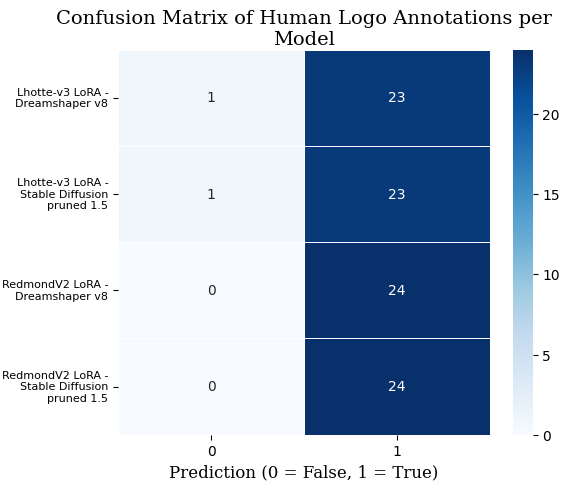

In [29]:
conf_matrix = df.groupby(['Model', 'Is it a logo?']).size().unstack(fill_value=0)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', linewidths=0.5)
plt.xlabel('Prediction (0 = False, 1 = True)', fontfamily='serif', fontsize=12)
plt.ylabel('Model', fontfamily='serif', fontsize=12)
plt.yticks(fontsize=8, wrap=True)
plt.title('Confusion Matrix of Human Logo Annotations per Model', fontfamily='serif', fontsize=14, loc='center', wrap=True)
plt.show()

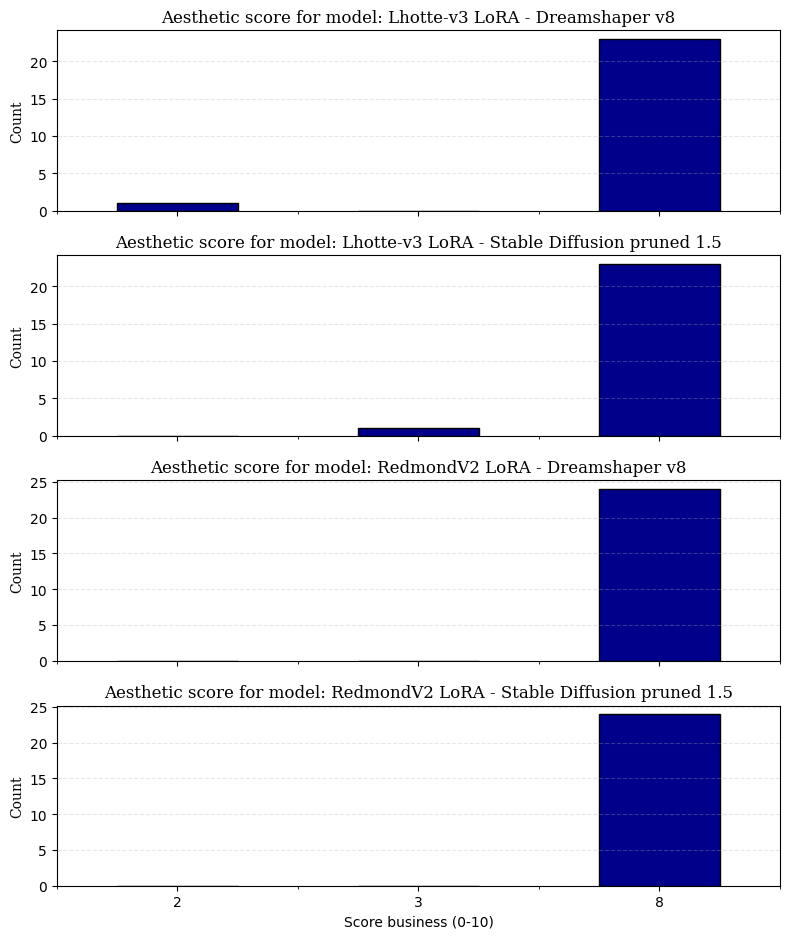

In [49]:
conf_matrix = df.groupby(['Model', 'Score business (0-10)']).size().unstack(fill_value=0)
models = conf_matrix.index

fig, axes = plt.subplots(nrows=len(models), ncols=1, figsize=(8, 2.5 * len(models)), sharex=True)
for ax, model in zip(axes, models):
    conf_matrix.loc[model].plot(kind='bar', color='darkblue', edgecolor='black', ax=ax)
    ax.set_title(f'Aesthetic score for model: {model}', fontfamily='serif', fontsize=12)
    ax.set_ylabel('Count', fontfamily='serif', fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    ax.set_xticks(range(len(conf_matrix.columns)))
    ax.set_xticklabels(conf_matrix.columns, rotation=0, fontsize=10)  
plt.tight_layout(rect=[0, 0.05, 1, 1])  
plt.show()


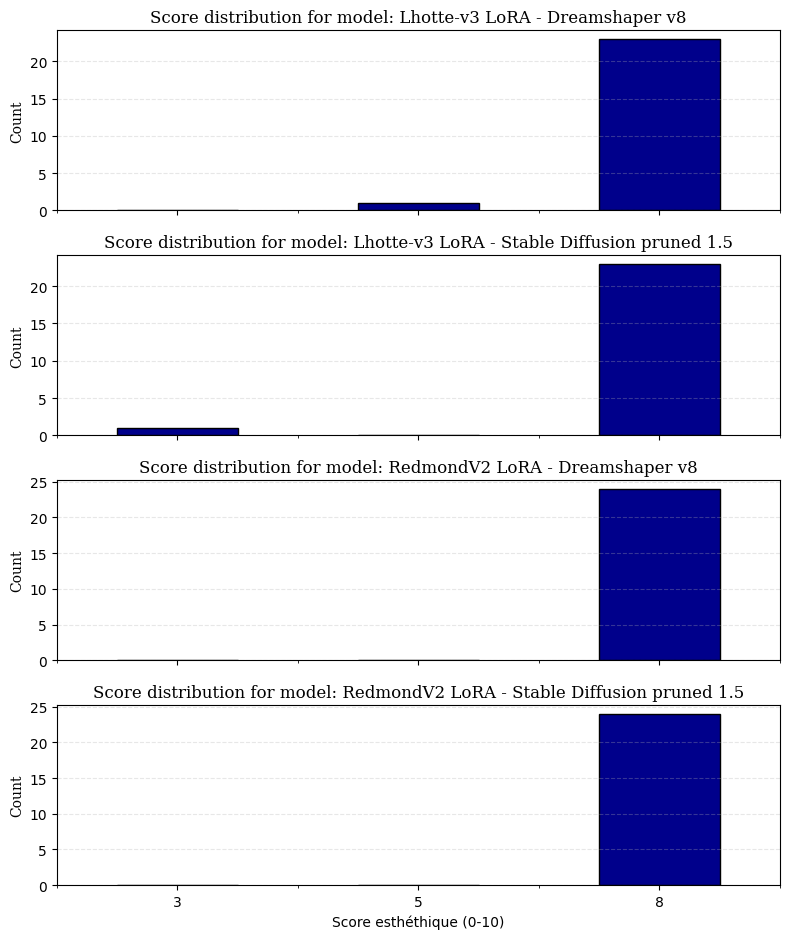

In [50]:
conf_matrix = df.groupby(['Model', 'Score esthéthique (0-10)']).size().unstack(fill_value=0)
models = conf_matrix.index


fig, axes = plt.subplots(nrows=len(models), ncols=1, figsize=(8, 2.5 * len(models)), sharex=True)
for ax, model in zip(axes, models):
    conf_matrix.loc[model].plot(kind='bar', color='darkblue', edgecolor='black', ax=ax)
    ax.set_title(f'Score distribution for model: {model}', fontfamily='serif', fontsize=12)
    ax.set_ylabel('Count', fontfamily='serif', fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    ax.set_xticks(range(len(conf_matrix.columns)))
    ax.set_xticklabels(conf_matrix.columns, rotation=0, fontsize=10)  

plt.tight_layout(rect=[0, 0.05, 1, 1])  
plt.show()

<Figure size 600x500 with 0 Axes>

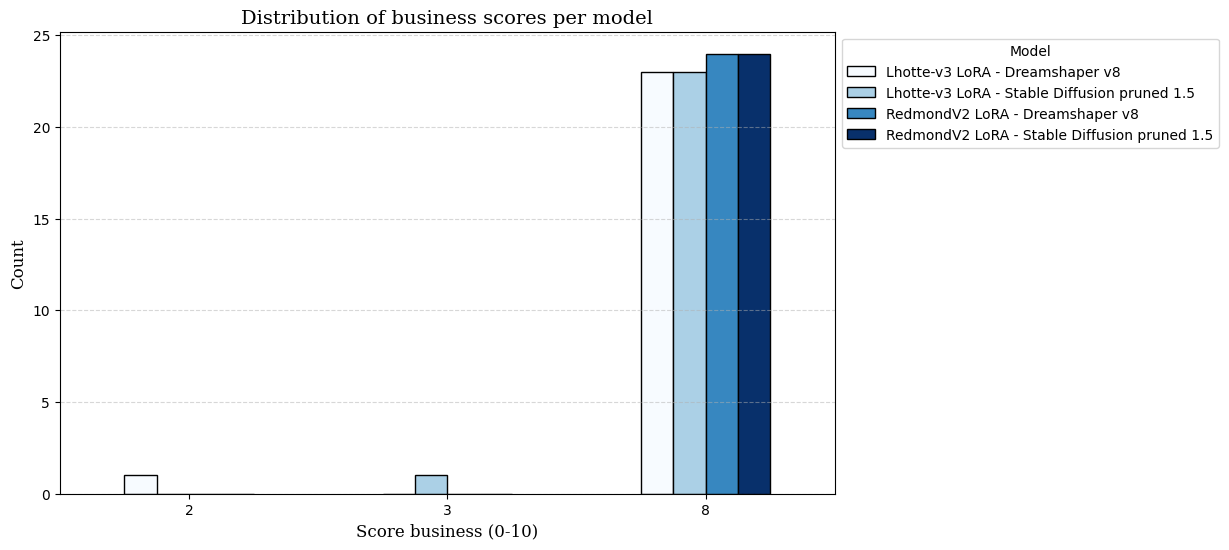

In [56]:
conf_matrix = df.groupby(['Model', 'Score business (0-10)']).size().unstack(fill_value=0)

# Plotting the grouped bar chart
plt.figure(figsize=(6, 5))
conf_matrix.T.plot(kind='bar', stacked=False, figsize=(10, 6), colormap='Blues', edgecolor='black')

plt.xlabel('Score business (0-10)', fontfamily='serif', fontsize=12)
plt.ylabel('Count', fontfamily='serif', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Model', bbox_to_anchor=(1, 1))
plt.title('Distribution of business scores per model', fontfamily='serif', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

<Figure size 600x500 with 0 Axes>

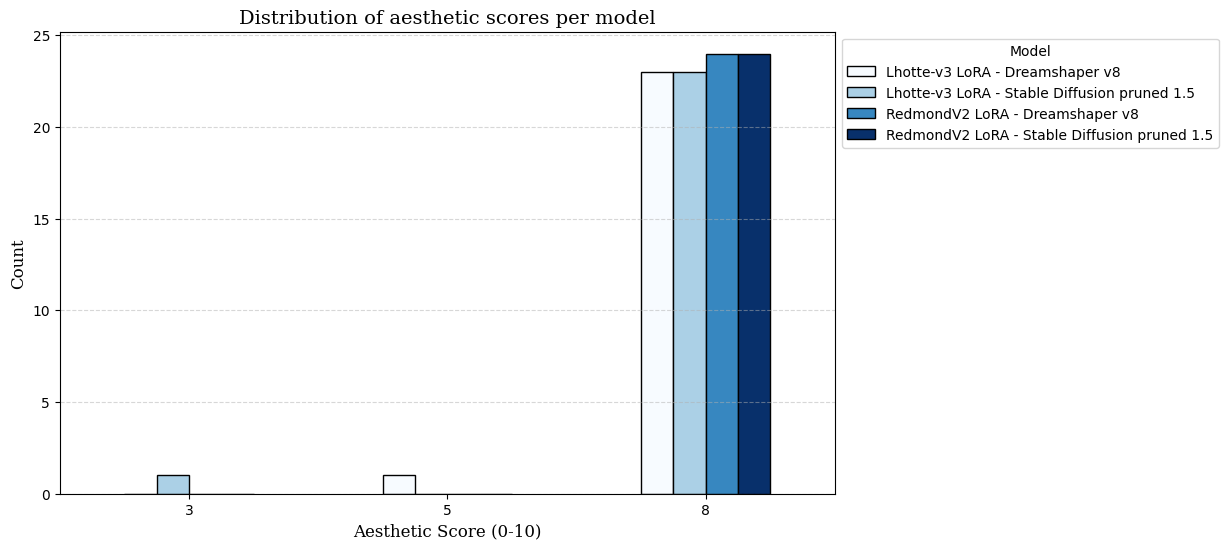

In [59]:
conf_matrix = df.groupby(['Model', 'Score esthéthique (0-10)']).size().unstack(fill_value=0)

# Plotting the grouped bar chart
plt.figure(figsize=(6, 5))
conf_matrix.T.plot(kind='bar', stacked=False, figsize=(10, 6), colormap='Blues', edgecolor='black')

plt.xlabel('Aesthetic Score (0-10)', fontfamily='serif', fontsize=12)
plt.ylabel('Count', fontfamily='serif', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Model', bbox_to_anchor=(1, 1))
plt.title('Distribution of aesthetic scores per model', fontfamily='serif', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# II - GPT-4o Score

# III - CLIP Score